# Business Problem: Stock Price Trend Prediction and Volatility Analysis

## Problem Statement:
- The stock market is inherently volatile, and predicting future stock prices can provide significant advantages for traders, investors, and financial institutions. The provided dataset contains daily trading data for a stock, including its opening, closing, highest, and lowest prices, as well as the trading volume. By analyzing this dataset, your goal is to predict future stock prices and assess stock volatility to make more informed trading decisions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
 # ! pip install -q kaggle

In [ ]:
! kaggle datasets download -d syedfaizanalii/nividia-stock-dataset-2023-2024
! mkdir nvidia-dataset
! unzip nividia-stock-dataset-2023-2024.zip -d nvidia-dataset

Dataset URL: https://www.kaggle.com/datasets/syedfaizanalii/nividia-stock-dataset-2023-2024
License(s): apache-2.0
  0% 0.00/15.0k [00:00<?, ?B/s]
100% 15.0k/15.0k [00:00<00:00, 17.7MB/s]
Archive:  nividia-stock-dataset-2023-2024.zip
  inflating: nvidia-dataset/nvidia_stock_data.csv  


In [ ]:
df = pd.read_csv('/content/nvidia-dataset/nvidia_stock_data.csv', parse_dates=['Date'])
df.head(5)

Date    Open    High     Low   Close  Adj Close     Volume
0 2023-01-03  14.851  14.996  14.096  14.315  14.305580  401277000
1 2023-01-04  14.567  14.853  14.241  14.749  14.739294  431324000
2 2023-01-05  14.491  14.564  14.148  14.265  14.255614  389168000
3 2023-01-06  14.474  15.010  14.034  14.859  14.849222  405044000
4 2023-01-09  15.284  16.056  15.141  15.628  15.617717  504231000

## About the dataset:

**Date:** The specific date of the trading day (YYYY-MM-DD format).

**Open:** The stock's price at the start of the trading day.

**High:** The highest price the stock reached during the trading day.

**Low:** The lowest price the stock reached during the trading day.

**Close:** The stock's price at the end of the trading day.

**Adj Close (Adjusted Close):** The closing price after adjustments for corporate actions such as dividends, stock splits, etc. It provides a more accurate reflection of the stock's value over time.

**Volume:** The total number of shares traded during the trading day.

## Step 1: Data Processing

### 1.1 Check Data Types

In [ ]:
print(df.dtypes)

Date             datetime64[ns]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Adj Close               float64
Volume                    int64
Daily_Returns           float64
dtype: object


In [ ]:
df.describe()

Date        Open        High         Low  \
count                            435  435.000000  435.000000  435.000000   
mean   2023-11-17 04:04:57.931034368   62.839067   64.020060   61.557228   
min              2023-01-05 00:00:00   14.474000   14.564000   14.034000   
25%              2023-06-12 12:00:00   40.318001   40.990002   39.485001   
50%              2023-11-15 00:00:00   47.629002   48.323002   46.750000   
75%              2024-04-23 12:00:00   90.078999   91.350502   88.417500   
max              2024-09-27 00:00:00  139.800003  140.759995  132.419998   
std                              NaN   34.822055   35.533695   33.878140   

            Close   Adj Close        Volume  Daily_Returns  
count  435.000000  435.000000  4.350000e+02     435.000000  
mean    62.856315   62.842841  4.556561e+08       0.005383  
min     14.265000   14.255614  1.739110e+08      -0.100046  
25%     40.218500   40.202612  3.603585e+08      -0.015009  
50%     47.569000   47.558792  4.277170e+08       0.004291  
75%     90.359501   90.344349  5.143315e+08       0.023050  
max    135.580002  135.568405  1.543911e+09       0.243696  
std     34.708923   34.710036  1.585719e+08       0.032905

### 1.2 Check for null values

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 1.3 Check for outliers
- We found 21 outliers in the Volume column.
- We will analyse these outliers in the analysing outliers section.

In [ ]:
# Calculate Q1 and Q3 for the entire DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate IQR for all columns
IQR = Q3 - Q1

# Identify outliers across all columns
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# Count the number of outliers in each column
outlier_counts_per_column = outliers.sum()

# Count the total number of outlier values
total_outlier_count = outliers.sum().sum()

print(f'Number of outliers in each column:\n{outlier_counts_per_column}')
print(f'Total number of outlier values: {total_outlier_count}')


Number of outliers in each column:
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       21
dtype: int64
Total number of outlier values: 21


In [ ]:
# Set the style
sns.set(style="whitegrid")

# Create a boxplot for all numeric columns
plt.figure(figsize=(14, 8))

# Select numeric columns only (to avoid non-numeric columns like Date, etc.)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create a boxplot for all numeric columns
sns.boxplot(data=df[numeric_cols], palette="Set3")

# Adding titles and labels
plt.title('Boxplot of All Numerical Columns (NVIDIA Stock)', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#### 1.4 Handling Outliers

## Step 2: Feature Engineering

### 2.1 Add Daily Returns column
- To calculate the daily percentage change in closing prices, you can use the ```pct_change()``` function in pandas. This function computes the percentage change between the current and previous row.
- Then remove the first row after calculating the daily percentage change because it contains a ```NAN``` value.

In [ ]:
df['Daily_Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)
df

Date        Open        High         Low       Close   Adj Close  \
1   2023-01-04   14.567000   14.853000   14.241000   14.749000   14.739294   
2   2023-01-05   14.491000   14.564000   14.148000   14.265000   14.255614   
3   2023-01-06   14.474000   15.010000   14.034000   14.859000   14.849222   
4   2023-01-09   15.284000   16.056000   15.141000   15.628000   15.617717   
5   2023-01-10   15.507000   15.962000   15.472000   15.909000   15.898532   
..         ...         ...         ...         ...         ...         ...   
432 2024-09-23  116.550003  116.989998  114.860001  116.260002  116.260002   
433 2024-09-24  116.519997  121.800003  115.379997  120.870003  120.870003   
434 2024-09-25  122.019997  124.940002  121.610001  123.510002  123.510002   
435 2024-09-26  126.800003  127.669998  121.800003  124.040001  124.040001   
436 2024-09-27  123.970001  124.029999  119.260002  121.400002  121.400002   

        Volume  Daily_Returns  
1    431324000       0.030318  
2    389168000      -0.032816  
3    405044000       0.041640  
4    504231000       0.051753  
5    384101000       0.017981  
..         ...            ...  
432  206228500       0.002241  
433  354966800       0.039653  
434  284692900       0.021842  
435  302582900       0.004291  
436  270161000      -0.021283  

[436 rows x 8 columns]

In [ ]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot the daily returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily_Returns'], color='blue', label='Daily Returns')

# Adding titles and labels
plt.title('NVIDIA Stock Daily Returns Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Returns', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a grid
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()


### 2.2 Add Moving Averages column
- Compute short-term (e.g., 5-day) and long-term (e.g., 50-day) moving averages to identify trends.

In [ ]:
df['Short_MA'] = df['Close'].rolling(window=5).mean()
df['Long_MA'] = df['Close'].rolling(window=50).mean()
df

Date        Open        High         Low       Close   Adj Close  \
1   2023-01-04   14.567000   14.853000   14.241000   14.749000   14.739294   
2   2023-01-05   14.491000   14.564000   14.148000   14.265000   14.255614   
3   2023-01-06   14.474000   15.010000   14.034000   14.859000   14.849222   
4   2023-01-09   15.284000   16.056000   15.141000   15.628000   15.617717   
5   2023-01-10   15.507000   15.962000   15.472000   15.909000   15.898532   
..         ...         ...         ...         ...         ...         ...   
432 2024-09-23  116.550003  116.989998  114.860001  116.260002  116.260002   
433 2024-09-24  116.519997  121.800003  115.379997  120.870003  120.870003   
434 2024-09-25  122.019997  124.940002  121.610001  123.510002  123.510002   
435 2024-09-26  126.800003  127.669998  121.800003  124.040001  124.040001   
436 2024-09-27  123.970001  124.029999  119.260002  121.400002  121.400002   

        Volume  Daily_Returns    Short_MA   Long_MA  
1    431324000       0.030318         NaN       NaN  
2    389168000      -0.032816         NaN       NaN  
3    405044000       0.041640         NaN       NaN  
4    504231000       0.051753         NaN       NaN  
5    384101000       0.017981   15.082000       NaN  
..         ...            ...         ...       ...  
432  206228500       0.002241  115.818001  115.9278  
433  354966800       0.039653  116.874002  115.7764  
434  284692900       0.021842  118.902002  115.7194  
435  302582900       0.004291  120.136002  115.8404  
436  270161000      -0.021283  121.216002  115.8466  

[436 rows x 10 columns]

### 2.3 Add TR and ATR
- The ATR helps traders assess the volatility of a stock. When the ATR is rising, the stock tends to experience higher volatility, and when the ATR is falling, the stock shows lower volatility.
- High ATR values indicate large price movements, while low ATR values suggest smaller price movements or low volatility.

In [ ]:
# Calculate True Range (TR)
df['Previous Close'] = df['Close'].shift(1)

df['TR'] = df[['High', 'Low']].apply(lambda x: x['High'] - x['Low'], axis=1)
df['TR_high_pc'] = abs(df['High'] - df['Previous Close'])
df['TR_low_pc'] = abs(df['Low'] - df['Previous Close'])

# True Range is the maximum of the three calculated ranges
df['TR'] = df[['TR', 'TR_high_pc', 'TR_low_pc']].max(axis=1)

# Calculate Average True Range (ATR) over a window, typically 14 periods
df['ATR'] = df['TR'].rolling(window=14).mean()

df.drop(['Previous Close', 'TR_high_pc', 'TR_low_pc'], axis=1, inplace=True)


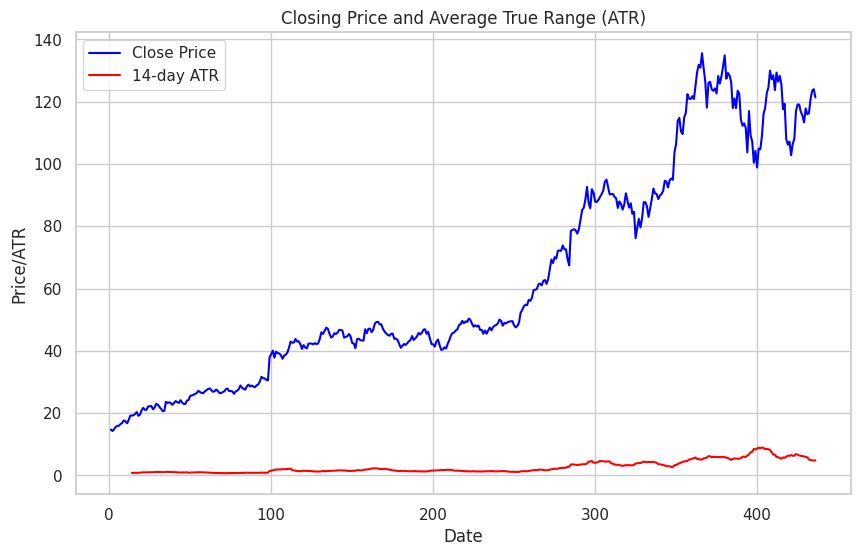

In [ ]:
# Plot Closing Price and ATR
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['ATR'], label='14-day ATR', color='red')

# Adding labels and title
plt.title('Closing Price and Average True Range (ATR)')
plt.xlabel('Date')
plt.ylabel('Price/ATR')
plt.legend()

# Show the plot
plt.show()


Based on the graph, several key observations can be made:

- Price trend: The closing price (blue line) shows a strong upward trend over time, with the price increasing from around 20 at the beginning to over 120 by the end of the period.
- Volatility increase: As the price rises, the volatility appears to increase, especially in the latter half of the chart where price swings become more pronounced.
- ATR trend: The 14-day Average True Range (ATR, red line) remains relatively low and stable for most of the period, but shows a slight increase towards the end, coinciding with the higher price volatility.
- Price acceleration: There's a noticeable acceleration in price growth around the 250-300 date range, where the slope of the price line becomes steeper.
- Recent consolidation: Towards the very end of the chart, there's a period of consolidation or slight pullback after reaching peak prices.
- Correlation: The ATR seems to have a loose positive correlation with price, generally increasing as the price increases, though the relationship is not strong throughout the entire period.

These observations suggest a security or asset that has experienced significant growth over time, with increasing volatility as its price has risen. The relatively low and stable ATR for most of the period indicates that despite the price increase, daily trading ranges remained somewhat consistent until the later stages of the trend.
For investors or traders, this chart might indicate a strong bullish trend with increasing risk (as measured by ATR) in the latter stages.

### 2.4 Add Bollinger Bands columns

In [ ]:
# Set the window for calculating the moving average and standard deviation
window = 20

# Calculate the Moving Average (Middle Band)
df['MA'] = df['Close'].rolling(window=window).mean()

# Calculate the standard deviation
df['STD'] = df['Close'].rolling(window=window).std()

# Calculate the Upper and Lower Bollinger Bands
df['Upper Band'] = df['MA'] + (df['STD'] * 2)
df['Lower Band'] = df['MA'] - (df['STD'] * 2)

# Drop any NaN values that may result from rolling calculations
df.dropna(inplace=True)

In [ ]:
df

Date        Open        High         Low       Close   Adj Close  \
50  2023-03-16   24.027000   25.587999   23.893999   25.541000   25.528532   
51  2023-03-17   25.982000   26.399000   25.667999   25.725000   25.712439   
52  2023-03-20   25.615000   26.024000   25.129999   25.900000   25.887354   
53  2023-03-21   26.180000   26.392000   25.381001   26.198999   26.186207   
54  2023-03-22   26.424999   27.589001   26.237000   26.468000   26.455076   
..         ...         ...         ...         ...         ...         ...   
432 2024-09-23  116.550003  116.989998  114.860001  116.260002  116.260002   
433 2024-09-24  116.519997  121.800003  115.379997  120.870003  120.870003   
434 2024-09-25  122.019997  124.940002  121.610001  123.510002  123.510002   
435 2024-09-26  126.800003  127.669998  121.800003  124.040001  124.040001   
436 2024-09-27  123.970001  124.029999  119.260002  121.400002  121.400002   

        Volume  Daily_Returns    Short_MA    Long_MA        TR       ATR  \
50   583253000       0.054193   23.952600   20.68170  1.694000  0.934429   
51   848547000       0.007204   24.504600   20.90122  0.858000  0.953286   
52   432747000       0.006803   25.091400   21.13392  0.894001  0.972929   
53   547408000       0.011544   25.518600   21.36072  1.011000  0.991714   
54   797295000       0.010268   25.966600   21.57752  1.390001  1.023286   
..         ...            ...         ...        ...       ...       ...   
432  206228500       0.002241  115.818001  115.92780  2.129997  5.127858   
433  354966800       0.039653  116.874002  115.77640  6.420006  4.932859   
434  284692900       0.021842  118.902002  115.71940  4.070000  4.874287   
435  302582900       0.004291  120.136002  115.84040  5.869995  4.779287   
436  270161000      -0.021283  121.216002  115.84660  4.779999  4.855001   

             MA       STD  Upper Band  Lower Band  
50    23.129500  1.184920   25.499339   20.759661  
51    23.315650  1.286550   25.888749   20.742551  
52    23.541250  1.325739   26.192729   20.889771  
53    23.818450  1.268868   26.356187   21.280713  
54    24.104150  1.182933   26.470016   21.738283  
..          ...       ...         ...         ...  
432  115.358500  7.086131  129.530763  101.186237  
433  115.079000  6.726315  128.531630  101.626371  
434  114.839500  6.302725  127.444951  102.234050  
435  114.761000  6.169897  127.100794  102.421207  
436  114.951501  6.318861  127.589223  102.313778  

[387 rows x 16 columns]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA'], label='Moving Average')
plt.plot(df['Date'], df['Upper Band'], label='Upper Band')
plt.plot(df['Date'], df['Lower Band'], label='Lower Band')
plt.fill_between(df['Date'], df['Lower Band'], df['Upper Band'], color='grey', alpha=0.3)
plt.legend(loc='best')
plt.title('Bollinger Bands')
plt.show()


Based on this Bollinger Bands chart, several key observations can be made:

- Overall uptrend: The asset's price has shown a strong upward trend from March 2023 to September 2024, rising from around $20 to over $120.
- Volatility changes: The width between the upper and lower Bollinger Bands has varied, indicating changes in volatility. It narrowed during periods of consolidation (e.g., late 2023) and widened during rapid price movements (e.g., mid-2024).
- Accelerated growth: There was a significant acceleration in price growth starting around January 2024, with the steepest climb occurring between March and May 2024.
- Recent consolidation: Since July 2024, the price has been consolidating, trading in a range between approximately $100 and $140.
- Band touches: The price has touched or exceeded the upper band several times during the uptrend, indicating strong bullish momentum. It has also touched the lower band occasionally, often followed by bounces.
- Volatility expansion: The recent consolidation phase shows wider Bollinger Bands compared to earlier periods, suggesting increased volatility.
- Moving average trend: The moving average (orange line) shows a clear upward slope, confirming the overall bullish trend.

Conclusions:

- The asset has been in a strong bull market over the past year and a half.
- The recent consolidation phase might indicate a potential pause in the uptrend or a preparation for the next move (either continuation or reversal).
- Volatility has increased in recent months, which could signal increased uncertainty or potential for larger price swings.
- The overall trend remains bullish as long as the price stays above the moving average and lower Bollinger Band.
- For traders or investors, this chart suggests maintaining a bullish bias but with increased caution due to the recent consolidation and higher volatility. It would be prudent to watch for a potential breakout from the current range for signals of the next significant move.

## Step 3: Exploratory Data Analysis

### 3.1 Visualize Stock Price Trends:

#### Plot the time series of Open, Close, High, Low prices

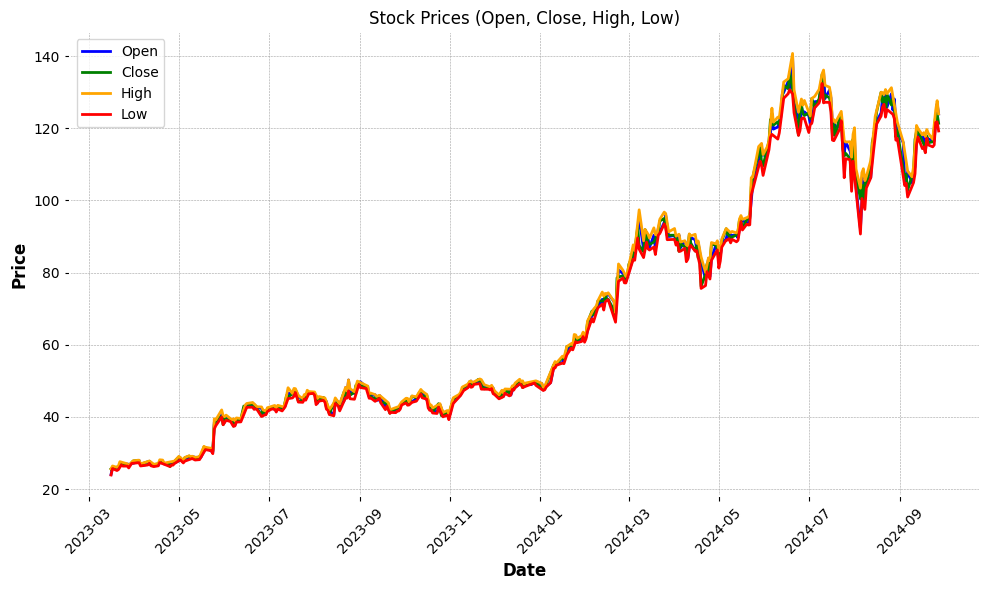

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['High'], label='High', color='orange')
plt.plot(df['Date'], df['Low'], label='Low', color='red')

plt.title('Stock Prices (Open, Close, High, Low)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


#### Plot moving averages to visualize trends over time.

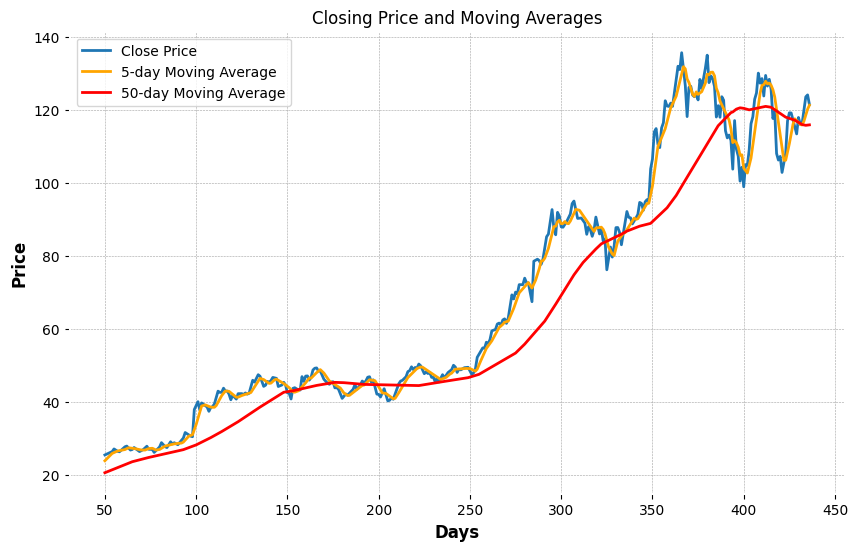

In [ ]:
# Plot the closing price and both moving averages
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Short_MA'], label='5-day Moving Average', color='orange')
plt.plot(df['Long_MA'], label='50-day Moving Average', color='red')

# Adding labels and title
plt.title('Closing Price and Moving Averages')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

### 3.2 Volume vs Price Movement

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the closing price on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='green')
ax1.plot(df['Date'], df['Close'], label='Close Price', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a second y-axis for the volume
ax2 = ax1.twinx()  # Instantiate a second axis that shares the same x-axis
ax2.set_ylabel('Volume', color='blue')
ax2.bar(df['Date'], df['Volume'], label='Volume', color='blue', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='blue')

# Add titles and layout
plt.title('Closing Price and Trading Volume')
fig.tight_layout()  # Ensure proper spacing
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

### 3.3 Price Volatility:

In [ ]:
# Create a figure to plot Bollinger Bands and ATR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Bollinger Bands with closing price on the first axis
ax1.plot(df['Date'], df['Close'], label='Close Price', color='green')
ax1.plot(df['Date'], df['MA'], label='20-Day MA', color='blue', linestyle='--')
ax1.plot(df['Date'], df['Upper Band'], label='Upper Band', color='orange', linestyle='--')
ax1.plot(df['Date'], df['Lower Band'], label='Lower Band', color='red', linestyle='--')
ax1.fill_between(df['Date'], df['Lower Band'], df['Upper Band'], color='grey', alpha=0.3)

ax1.set_title('Bollinger Bands')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='best')
ax1.grid(True)

# Plot ATR on the second axis
ax2.plot(df['Date'], df['ATR'], label='ATR (20-Day)', color='purple')
ax2.set_title('Average True Range (ATR)')
ax2.set_xlabel('Date')
ax2.set_ylabel('ATR')
ax2.legend(loc='best')
ax2.grid(True)

plt.tight_layout()
plt.xticks(rotation=45)

# Show plot
plt.show()

### 3.4 Correlations:

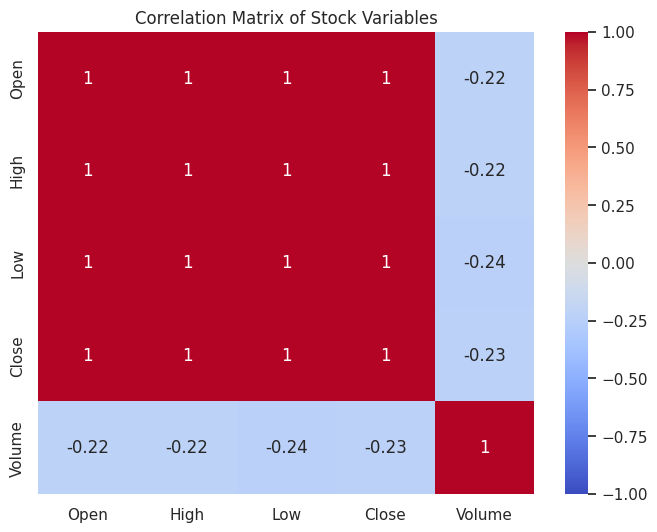

In [ ]:
# Compute the correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stock Variables')
plt.show()


This correlation matrix provides several key insights about the relationships between different stock variables:

- Price variables correlation: Open, High, Low, and Close prices are perfectly correlated (correlation coefficient of 1) with each other. This indicates that these price metrics move in perfect unison.


- Volume and price relationship: Volume shows a weak negative correlation with all price variables (Open, High, Low, Close), with coefficients ranging from -0.22 to -0.24.
This suggests that as prices increase, trading volume tends to slightly decrease, and vice versa, though the relationship is not strong.


- Volume autocorrelation: Volume has a perfect positive correlation (1) with itself, which is expected in a correlation matrix diagonal.


- Symmetry: The matrix is symmetrical, as expected for a correlation matrix.


- Strength of relationships: The relationships between price variables are very strong (perfect correlation).
The relationship between volume and price variables is weak and inverse.

- Conclusions: Price movements are highly synchronized across all price metrics (Open, High, Low, Close).
There's a slight tendency for volume to move in the opposite direction of price, but this relationship is weak.
The strong correlation between price variables suggests that knowing one price metric can reliably predict the others.
The weak negative correlation with volume implies that volume alone may not be a strong predictor of price movements or vice versa.
Traders or analysts should be aware that these price variables don't provide unique information due to their perfect correlation, and may want to consider additional factors or technical indicators for a more comprehensive analysis.

## Step 4: Time Series Analysis for Trend Detection

### 4.1 Decompose Time Series:

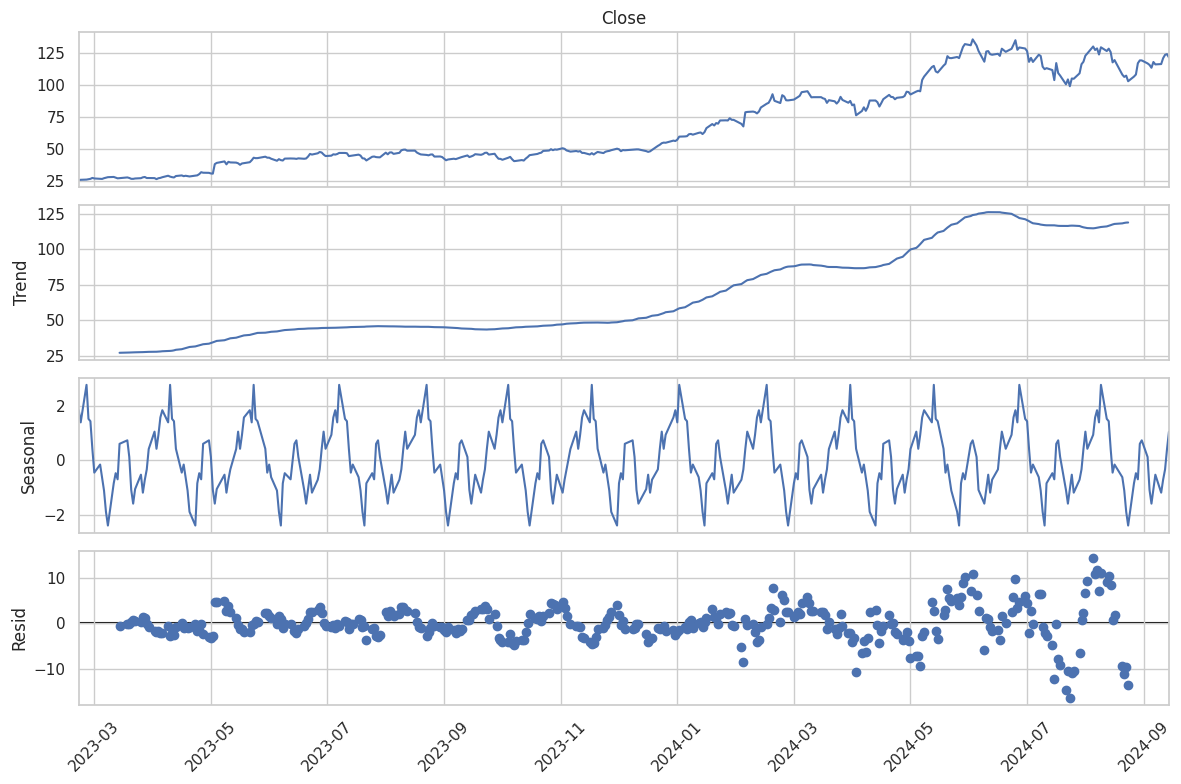

In [ ]:
# import statsmodels.api as sm

# df.set_index('Date', inplace = True)

# results = sm.tsa.seasonal_decompose(df['Close'], model = 'additive', period=30)
# results.plot()
# plt.show()

#import matplotlib.pyplot as plt
import statsmodels.api as sm

df.set_index('Date', inplace = True)

# Decompose the time series
results = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=30)

# Plot the decomposition
fig = results.plot()

# Adjust the figure size (optional if you want more space)
fig.set_size_inches(12, 8)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Optional: Format the x-axis to show fewer labels (you can change interval to suit your data)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

# Optional: Format date labels (this will depend on your data's frequency)
fig.axes[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Show the plot
plt.tight_layout()
plt.show()


This time series decomposition chart provides several insights about the stock's behavior:

- Close Price (Top Panel):

  - Overall upward trend from around $40 to over $100 over the period.
Significant acceleration in growth starting around early 2024.
Recent consolidation or slight pullback near the end of the period.


- Trend (Second Panel):

  - Confirms the overall upward trend seen in the close price.
Smooths out short-term fluctuations, showing a clearer picture of long-term movement.
Steepest increase occurs in the first half of 2024.


- Seasonal Component (Third Panel):

  - Clear repeating pattern, suggesting cyclical behavior in the stock price.
Cycle appears to repeat roughly every 2-3 months.
Amplitude of seasonal fluctuations remains fairly consistent throughout the period.


- Residual Component (Bottom Panel):

  - Represents the variations not explained by the trend or seasonal components.
  - Increased volatility in residuals towards the end of the period, with larger positive and negative spikes.
  - This suggests higher unpredictability or influence of external factors in recent months.



- Conclusions:

- The stock has shown strong overall growth, particularly accelerating in early 2024.
- There's a consistent seasonal pattern in the stock's price movements, which could be useful for short-term trading strategies.
- The increased residual volatility in recent months indicates higher market uncertainty or sensitivity to news/events.
- The recent flattening of the trend line suggests a possible slowdown in growth or consolidation phase.
- Traders might use this information to:

  - Align longer-term positions with the overall upward trend.
  - Consider the seasonal pattern for timing entry and exit points.
  - Be cautious of increased short-term unpredictability as shown by recent residuals.

### 4.2 Plot the original data and rolling mean (20-Days window)

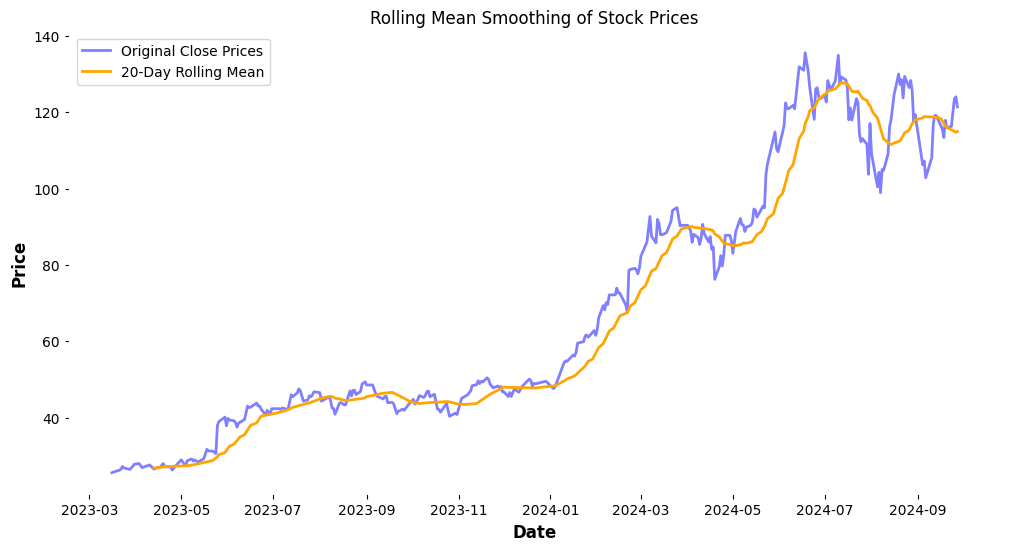

In [ ]:
df['Rolling Mean'] = df['Close'].rolling(window=20).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Original Close Prices', color='blue', alpha=0.5)
plt.plot(df['Rolling Mean'], label='20-Day Rolling Mean', color='orange')
plt.title('Rolling Mean Smoothing of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-16   24.027000   25.587999   23.893999   25.541000   25.528532   
2023-03-17   25.982000   26.399000   25.667999   25.725000   25.712439   
2023-03-20   25.615000   26.024000   25.129999   25.900000   25.887354   
2023-03-21   26.180000   26.392000   25.381001   26.198999   26.186207   
2023-03-22   26.424999   27.589001   26.237000   26.468000   26.455076   
...                ...         ...         ...         ...         ...   
2024-09-23  116.550003  116.989998  114.860001  116.260002  116.260002   
2024-09-24  116.519997  121.800003  115.379997  120.870003  120.870003   
2024-09-25  122.019997  124.940002  121.610001  123.510002  123.510002   
2024-09-26  126.800003  127.669998  121.800003  124.040001  124.040001   
2024-09-27  123.970001  124.029999  119.260002  121.400002  121.400002   

               Volume  Daily_Returns    Short_MA    Long_MA        TR  \
Date                                                                    
2023-03-16  583253000       0.054193   23.952600   20.68170  1.694000   
2023-03-17  848547000       0.007204   24.504600   20.90122  0.858000   
2023-03-20  432747000       0.006803   25.091400   21.13392  0.894001   
2023-03-21  547408000       0.011544   25.518600   21.36072  1.011000   
2023-03-22  797295000       0.010268   25.966600   21.57752  1.390001   
...               ...            ...         ...        ...       ...   
2024-09-23  206228500       0.002241  115.818001  115.92780  2.129997   
2024-09-24  354966800       0.039653  116.874002  115.77640  6.420006   
2024-09-25  284692900       0.021842  118.902002  115.71940  4.070000   
2024-09-26  302582900       0.004291  120.136002  115.84040  5.869995   
2024-09-27  270161000      -0.021283  121.216002  115.84660  4.779999   

                 ATR          MA       STD  Upper Band  Lower Band  \
Date                                                                 
2023-03-16  0.934429   23.129500  1.184920   25.499339   20.759661   
2023-03-17  0.953286   23.315650  1.286550   25.888749   20.742551   
2023-03-20  0.972929   23.541250  1.325739   26.192729   20.889771   
2023-03-21  0.991714   23.818450  1.268868   26.356187   21.280713   
2023-03-22  1.023286   24.104150  1.182933   26.470016   21.738283   
...              ...         ...       ...         ...         ...   
2024-09-23  5.127858  115.358500  7.086131  129.530763  101.186237   
2024-09-24  4.932859  115.079000  6.726315  128.531630  101.626371   
2024-09-25  4.874287  114.839500  6.302725  127.444951  102.234050   
2024-09-26  4.779287  114.761000  6.169897  127.100794  102.421207   
2024-09-27  4.855001  114.951501  6.318861  127.589223  102.313778   

            Rolling Mean  
Date                      
2023-03-16           NaN  
2023-03-17           NaN  
2023-03-20           NaN  
2023-03-21           NaN  
2023-03-22           NaN  
...                  ...  
2024-09-23    115.358500  
2024-09-24    115.079000  
2024-09-25    114.839500  
2024-09-26    114.761000  
2024-09-27    114.951501  

[387 rows x 16 columns]